# Prepare Lorenz data for LSTM training

In [1]:
from math import ceil
import os
import random

import numpy
import torch

from examples.forwardModel import forwardModel_r

if not os.path.exists(local_data_name := "lorenz_data4lstm.data"):
    random.seed(0)
    numpy.random.seed(0)
    torch.manual_seed(0)
    device = "cpu"

    # We define the control parameters here
    rayleigh = 35
    prandtl = 10.0
    b = 8.0 / 3.0
    # initial condition for the true reference trajectory
    x0 = torch.tensor([0.0, 1.0, 2.0], device=device)

    # integration time parameter
    dt = 1.0e-3  # This is time step size
    T = 500.0  # Total integration time, can be as short as 10 to speed things up
    n_steps = ceil(T / dt)
    time = torch.linspace(
        0.0, T, n_steps + 1, device=device
    )  # array of discrete times

    # numerical integration given initial conditions and control parameters
    xt = forwardModel_r(x0, time, rayleigh, prandtl, b)

    print(f"{xt.shape=}, {xt.dtype=}")

    torch.save(xt.T, local_data_name)
    data = torch.load(local_data_name)

    print(f"{torch.allclose(data, xt.T)=}")

# Setup random device and seed

In [2]:
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


def set_device():
    """
    Use CPU if cuda device is not available
    setup tf32 for faster GPU computation
    """
    if torch.cuda.device_count() == 0:
        return "cpu"
    torch.set_float32_matmul_precision("high")
    return "cuda"


set_seed(0)
g = torch.Generator()
g.manual_seed(0)

# Customized Network Architecture

In [3]:
class LSTM_1TON(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, out_seq_length):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.out_seq_length = out_seq_length

        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor):
        x_inner = x.view(1, 1, -1) if x.ndim in (1, 2) else x
        x0 = self.fc_in(x)
        hn = x0.clone().view(1, x_inner.size(0), self.hidden_dim).repeat(self.num_layers, 1, 1)
        cn = hn.clone()
        # hn = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), device=x.device)
        # cn = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), device=x.device)
        outs = [0] * self.out_seq_length
        for i in range(self.out_seq_length):
            x_inner, (hn, cn) = self.lstm(x_inner, (hn, cn))
            x_inner = self.fc(F.elu(x_inner))
            outs[i] = x_inner
        ret = torch.cat(outs, dim=1)
        return ret.squeeze_(0) if x.ndim in (1, 2) else ret

    # def forward(self, x: torch.Tensor):
    #     x0 = self.fc_in(x)
    #     h0 = x0.clone().view(1, x.size(0), self.hidden_dim).repeat(self.num_layers, 1, 1)
    #     c0 = h0.clone()
    #     out, _ = self.lstm(x, (h0, c0))
    #     return self.fc(F.elu(out))

# Define how to feed data

In [4]:
class SeqDataset(Dataset):
    def __init__(self, valid_ratio=0.01, seq_length=1):
        self.seq_length = seq_length
        # default `u` path is `data/u/`
        self.data = torch.load("lorenz_data4lstm.data")
        num_all_samples = self.data.size(0)
        # keep indices sequential
        slice_idx = int(valid_ratio * num_all_samples)
        self.train_data = self.data[:-slice_idx]
        self.valid_data = self.data[-slice_idx:]
        self.train()

    def train(self):
        # total number of samples counted by sliding the training sample window forward 1 step each time
        self.num_samples = len(self.train_data) - 2 * self.seq_length + 1
        self.idxs = self.train_data

    def eval(self):
        # total number of samples counted by sliding the training sample window forward 1 step each time
        self.num_samples = len(self.valid_data) - 2 * self.seq_length + 1
        self.idxs = self.valid_data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, i):
        # get model input and predict samples at the same time
        # (model input --> samples[:seq_length], predict --> samples[seq_length:])
        # for j in range(i, i + 2 * self.seq_length):
        #     print(os.path.join(self.imgs_folder_path, f"{self.idxs[j]}.png"))
        return self.idxs[i:i + 2 * self.seq_length]

# Initialize model

In [5]:
lstm_model = LSTM_1TON(3, 12, 20, 3, 99)
sum(p.numel() for p in lstm_model.parameters())

24615

# Training steps

In [6]:
def train_LSTM_model(data, lstm_model, epochs, device="cpu"):
    lstm_model = lstm_model.to(device)
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=7.5e-3)
    liveloss = PlotLosses(groups={"Loss": ["train loss", "valid loss"]})
    for _ in range(epochs):
        train_loss, valid_loss = 0, 0
        lstm_model.train()
        data.train()
        for seqs in DataLoader(
            dataset=data, batch_size=2048, shuffle=True, num_workers=4
        ):
            seqs = seqs.to(device)
            # use encoder to get latent vectors
            # training step
            seqs, out_seqs = seqs[:, :1], seqs[:, 1:]
            optimizer.zero_grad(set_to_none=True)
            out = lstm_model(seqs)
            loss = F.mse_loss(out, out_seqs, reduction="sum")
            loss.backward()
            optimizer.step()
            # accumulate for average train loss
            train_loss += loss
        # calculate average train loss
        avg_train_loss = (train_loss / len(data)).item()
        # switch to eval mode
        lstm_model.eval()
        data.eval()
        with torch.no_grad():
            for seqs in DataLoader(
                dataset=data, batch_size=8192, shuffle=False, num_workers=4
            ):
                seqs = seqs.to(device)
                # eval step
                seqs, out_seqs = seqs[:, :1], seqs[:, 1:]
                out = lstm_model(seqs)
                loss = F.mse_loss(out, out_seqs, reduction="sum")
                # accumulate for average valid loss
                valid_loss += loss
        # update plot
        logs = {
            "train loss": avg_train_loss,
            "valid loss": (valid_loss / len(data)).item(),
        }
        liveloss.update(logs)
        liveloss.draw()
    return lstm_model


lstm_data = SeqDataset(seq_length=50)
# save parameters to save training time
if os.path.exists("lstm4lorenz_model_1to99.pt"):
    lstm_model.load_state_dict(torch.load("lstm4lorenz_model_1to99.pt", map_location="cpu"))
else:
    device = set_device()
    lstm_model = train_LSTM_model(lstm_data, lstm_model, epochs=100, device=device)
    torch.save(lstm_model.state_dict(), "lstm4lorenz_model_1to99.pt")
device = "cpu"

# Construct observations in a time window

In [7]:
from deepda import apply_KF, apply_EnKF

In [8]:
# We define the control parameters here
rayleigh = 35
prandtl = 10.
b = 8./3.
# initial condition for the true reference trajectory
x0 = torch.tensor([0., 1., 2.], device=device)

# integration time parameter
dt = 1.e-3      # This is time step size
T = 25.         # Total integration time, can be as short as 10 to speed things up
num_steps = ceil(T / dt)
time = torch.linspace(0., T, num_steps + 1, device=device)  # array of discrete times

# numerical integration given initial conditions and control parameters
xt = forwardModel_r(x0, time, rayleigh, prandtl, b)

In [9]:
# Which variables do we observe?
WhichVariablesAreObserved = torch.tensor([1, 1, 1])
#  Determines which variables are available to
#  the EnKF. For example:
#  WhichVariablesAreObserved = [1 1 1];
#  means: X, Y, Z are observed
#  WhichVariablesAreObserved = [1 0 1];
#  means: X and Z are observed
#  WhichVariablesAreObserved = [1 0 0];
# means: X is observed
sigobs = 1e-3  # standard deviation of the observation noise
# We generate the synthetic data
#  Construct observation matrix H
#  ........................................................................
y_size = int(WhichVariablesAreObserved.sum())
# Callable H
def H(x: torch.Tensor):
    h = torch.zeros((y_size, 3), device=device)
    iy = 0
    for ix in range(3):
        if WhichVariablesAreObserved[ix] > 0:
            h[iy, ix] = 1.
            iy += 1
    return h @ x
# # Tensor H
# H = torch.zeros((y_size, 3), device=device)
# iy = 0
# for ix in range(3):
#     if WhichVariablesAreObserved[ix] > 0:
#         H[iy, ix] = 1.
#         iy += 1

In [10]:
# How often do we observe the true state?
dtobs = 0.5  # time between observations
# no observation at t=0
gap = int(dtobs / dt)  # number of time steps between each observation
time_obs = time[gap::gap]
# Generate vector of observations
R = (sigobs**2) * torch.eye(y_size, device=device)
sqrt_s = torch.sqrt(R)
# y = Hxt
y = H @ xt[:, gap::gap] if isinstance(H, torch.Tensor) else H(xt[:, gap::gap])
# compute observation error
# noise = sqrt_s @ torch.randn(size=y.shape, device=device)
# y = Hxt + epsilon
# y = y + noise

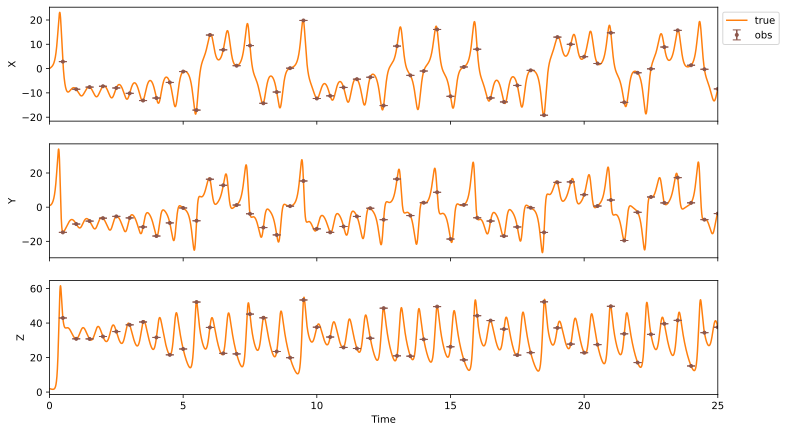

In [11]:
# Plot reference trajectory and the observations that will be fed to the EnKF
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 7), sharex=True)
iobs = 0
for k, comp in enumerate(["X", "Y", "Z"]):
    ax[k].plot(time.cpu(), xt.cpu()[k, :], color="#ff7f0e", label='true')
    if WhichVariablesAreObserved[k] > 0:
        ax[k].errorbar(time_obs.cpu(), y.cpu()[iobs, :],
                       yerr=sqrt_s.cpu()[iobs, iobs], color="#8c564b",
                       fmt='o', markersize=3, capsize=4, label='obs')
        # ax[k].legend(bbox_to_anchor=(1, 1), loc='best', frameon=True)
        iobs += 1
    ax[k].set_ylabel(comp)
ax[-1].set_xlabel('Time')
ax[-1].set_xlim(time.cpu()[0], time.cpu()[-1])
# fig.suptitle('Reference trajectory + observations')
ax[0].legend(bbox_to_anchor=(1, 1), loc='best', frameon=True)
plt.show()

# Forward prediction test without EnKF

In [12]:
lstm_model = lstm_model.to(device)
lstm_model.eval()

LSTM_1TON(
  (fc_in): Linear(in_features=3, out_features=12, bias=True)
  (lstm): LSTM(3, 12, num_layers=20, batch_first=True)
  (fc): Linear(in_features=12, out_features=3, bias=True)
)

In [13]:
# xtT = xt.T
# lstm_outs = [xtT[0]]
# next_in = lstm_outs[0]
# with torch.no_grad():
#     while len(lstm_outs) < (xtT.size(0) // lstm_model.out_seq_length):
#         # print(f"{next_in.shape=}")
#         outs = lstm_model(next_in)
#         lstm_outs.append(outs)
#         next_in = outs[-1]
#     # for i in range(0, xtT.size(0)-1, 99):
#     #     lstm_outs[i+1:i+100] = lstm_model(lstm_outs[i].view(1, 1, 3)).view(-1, 3)
#     # for i in range(0, xtT.size(0)-1, 5):
#     #     lstm_outs[i+1:i+6] = lstm_model(lstm_outs[i].view(1, 1, 3)).view(-1, 3)
#         # lstm_outs[i+1] = lstm_model(lstm_outs[i].view(1, 1, 3)).view(1, 3)
# lstm_outs = torch.cat(lstm_outs)
# full_range = torch.zeros_like(xtT)
# full_range[:lstm_outs.size(0)] = lstm_outs
# lstm_outs = full_range
# lstm_outs.shape
xtT = xt.T
lstm_outs = [xtT0.view(1, -1) if (xtT0:=xtT[0]).ndim == 1 else xtT0]
next_in = lstm_outs[0]
with torch.no_grad():
    forward_times, residue = divmod(xtT.size(0)-1, lstm_model.out_seq_length)
    for _ in range(forward_times+1):
        outs = lstm_model(next_in)
        lstm_outs.append(outs)
        next_in = outs[-1]
    lstm_outs[-1] = lstm_outs[-1][:residue]
    lstm_outs = torch.cat(lstm_outs).T
lstm_outs.shape

torch.Size([3, 25001])

In [14]:
# Compute Euclidean error wrt true state which is known in this synthetic game
# cumulative error
cum_error_comp = torch.sum((xt - lstm_outs.detach().numpy()) ** 2, dim=1)
cum_error = torch.sum(cum_error_comp)
norm_comp = torch.sum(xt**2, dim=1)
norm = torch.sum(xt**2)
print("No DA Relative errors (RRMSE) in %")
for k, comp in enumerate(["X", "Y", "Z"]):
    print(f"{comp}-component: {100.0 * torch.sqrt(cum_error_comp[k] / norm_comp[k]):.1f}")
print(f"3-component: {100.0 * torch.sqrt(cum_error / norm):.1f}\n")
print("No DA Relative errors (MSE) in %")
print(f"3-component: {100.0 * torch.mean((xt - lstm_outs.detach().numpy()) ** 2):.1f}")

No DA Relative errors (RRMSE) in %
X-component: 135.8
Y-component: 136.6
Z-component: 29.5
3-component: 60.4

No DA Relative errors (MSE) in %
3-component: 15186.5


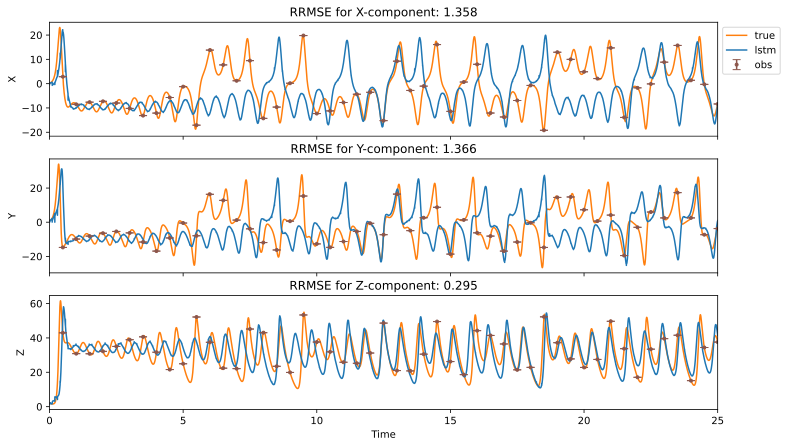

In [15]:
# cum_error_comp = torch.mean((xt - lstm_outs.detach().numpy()) ** 2, dim=1)
cum_error_comp = torch.sum((xt - lstm_outs.detach().numpy()) ** 2, dim=1)
norm_comp = torch.sum(xt**2, dim=1)
# Plot reference trajectory and the observations that will be fed to the EnKF
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 7), sharex=True)
iobs = 0
for k, comp in enumerate(["X", "Y", "Z"]):
    ax[k].plot(time.cpu(), xt.cpu()[k, :], color="#ff7f0e", label='true')
    ax[k].plot(time.cpu(), lstm_outs.detach().numpy()[k, :], color="#1f77b4", label='lstm')
    if WhichVariablesAreObserved[k] > 0:
        ax[k].errorbar(time_obs.cpu(), y.cpu()[iobs, :],
                       yerr=sqrt_s.cpu()[iobs, iobs], color="#8c564b",
                       fmt='o', markersize=3, capsize=4, label='obs')
        # ax[k].legend(bbox_to_anchor=(1, 1), loc='best', frameon=True)
        iobs += 1
    ax[k].set_ylabel(comp)
    ax[k].title.set_text(
        # f"RRMSE for {comp}-component: {100 * torch.sqrt(cum_error_comp[k] / norm_comp[k]):.3f}%"
        f"RRMSE for {comp}-component: {torch.sqrt(cum_error_comp[k] / norm_comp[k]):.3f}"
    )
ax[-1].set_xlabel('Time')
ax[-1].set_xlim(time.cpu()[0], time.cpu()[-1])
ax[0].legend(bbox_to_anchor=(1, 1), loc='best', frameon=True)
plt.show()

# Forward prediction test with EnKF

In [16]:
# Initialization of the Ensemble
Ne = 50  # Number of ensemble members
# The ensemble is centered on a zero initial condition
x0ens = torch.tensor([0., 0., 0.], device=device)
sigens = 1.  # standard deviation of the ensemble
# initial covariance matrix
P0 = (sigens**2)*torch.eye(3, device=device)

In [17]:
# Callable H
def H(x: torch.Tensor):
    h = torch.zeros((y_size, 3), device=device)
    iy = 0
    for ix in range(3):
        if WhichVariablesAreObserved[ix] > 0:
            h[iy, ix] = 1.
            iy += 1
    return x @ h.T
# # Tensor H
# H = torch.zeros((y_size, 3), device=device)
# iy = 0
# for ix in range(3):
#     if WhichVariablesAreObserved[ix] > 0:
#         H[iy, ix] = 1.
#         iy += 1

In [18]:
# Now we run the EnKF
gaps = [gap] * len(time_obs)
# xEnKF, x_ens = apply_EnKF(
#     time_obs, gaps, Ne, M, H, P0, R, xtT[0], y.T
# )
# xEnKF, x_ens = xEnKF.T, x_ens.transpose(0, -1)

In [19]:
# def M(x, time_fw, *args):
#     outs = [x0.view(1, -1) if (x0:=x).ndim == 1 else x]
#     x = outs[0]
#     forward_times, residue = divmod(len(time_fw[:-1]), lstm_model.out_seq_length)
#     for _ in range(forward_times+1):
#         x = lstm_model(x)
#         outs.append(x)
#         x = x[-1]
#     outs[-1] = outs[-1][:residue]
#     return torch.cat(outs)


# # KF is only accessible from raw API
# x_estimates = apply_KF(
#     time_obs, gaps, M, H, P0, R, xtT[0], y.T
# )
# x_estimates = x_estimates.T

In [20]:
import deepda

parameters = deepda.Parameters(
    algorithm=deepda.Algorithms.EnKF,
    device=deepda.Device.CPU,
    observation_time_steps=time_obs,
    gaps=gaps,
    num_ensembles=Ne,
    observation_model=H,
    output_sequence_length=lstm_model.out_seq_length,
    forward_model=lstm_model,
    background_covariance_matrix=P0,
    observation_covariance_matrix=R,
    background_state=xtT[0],
    observations=y.T,
)

run_case = deepda.CaseBuilder(parameters=parameters)

if parameters.device is deepda.Device.GPU:

    def H(x: torch.Tensor):
        h = torch.zeros((y_size, 3), device="cuda")
        iy = 0
        for ix in range(3):
            if WhichVariablesAreObserved[ix] > 0:
                h[iy, ix] = 1.
                iy += 1
        return x @ h.T

    run_case.set_observation_model(H)

enkf_res = "xEnKF.data"
all_enkf_res = "x_ens.data"
if not (os.path.exists(enkf_res) and os.path.exists(all_enkf_res)):
    results = run_case.execute()
    xEnKF, x_ens = results["average_ensemble_all_states"].T.to("cpu"), results["each_ensemble_all_states"].transpose(0, -1).to("cpu")
    torch.save(xEnKF, enkf_res)
    torch.save(x_ens, all_enkf_res)
else:
    xEnKF = torch.load(enkf_res, map_location="cpu")
    x_ens = torch.load(all_enkf_res, map_location="cpu")

In [21]:
# Compute Euclidean error wrt true state which is known in this synthetic game
# cumulative error
# cum_error_comp = torch.sqrt(torch.sum((xt - x_estimates) ** 2, dim=1))
cum_error_comp = torch.sum((xt - xEnKF) ** 2, dim=1)
cum_error = torch.sum(cum_error_comp)
norm_comp = torch.sum(xt**2, dim=1)
norm = torch.sum(xt**2)
print("EnKF Relative errors (RRMSE) in %")
for k, comp in enumerate(["X", "Y", "Z"]):
    print(f"{comp}-component: {100.0 * torch.sqrt(cum_error_comp[k] / norm_comp[k]):.1f}")
print(f"3-component: {100.0 * torch.sqrt(cum_error / norm):.1f}\n")
print("EnKF Relative errors (MSE) in %")
print(f"3-component: {100.0 * torch.mean((xt - xEnKF) ** 2):.1f}")

EnKF Relative errors (RRMSE) in %
X-component: 98.5
Y-component: 101.5
Z-component: 27.5
3-component: 47.1

EnKF Relative errors (MSE) in %
3-component: 9214.7


In [22]:
all_3component_error = []
for e in range(Ne):
    cum_error_comp_one = torch.sum((xt - x_ens[:, e]) ** 2, dim=1)
    cum_error_one = torch.sum(cum_error_comp_one)
    all_3component_error.append(float(100.0 * torch.sqrt(cum_error_one / norm)))
print(f"max error in all components: {max(all_3component_error)}%")

max error in all components: 48.68949508666992%


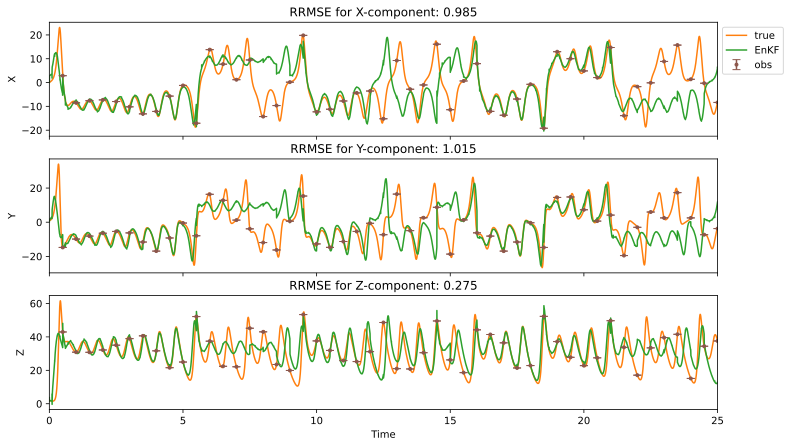

In [23]:
# Plot results
# cum_error_comp = torch.mean((xt - xEnKF) ** 2, dim=1)
cum_error_comp = torch.sum((xt - xEnKF) ** 2, dim=1)
norm_comp = torch.sum(xt**2, dim=1)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 7), sharex=True)
iobs = 0
for k, comp in enumerate(["X", "Y", "Z"]):
    ax[k].plot(time.cpu(), xt.cpu()[k, :], color="#ff7f0e", label='true')
    ax[k].plot(time.cpu(), xEnKF.cpu()[k, :], color="#2ca02c", label='EnKF')
    # ax[k].plot(time.cpu(), x_estimates.cpu()[k, :], label='EnKF')
    if WhichVariablesAreObserved[k] > 0:
        ax[k].errorbar(time_obs.cpu(), y.cpu()[iobs, :],
                       yerr=sqrt_s.cpu()[iobs, iobs], color="#8c564b",
                       fmt='o', markersize=3, capsize=4, label='obs')
        iobs += 1
    # ax[k].legend(bbox_to_anchor=(1, 1), loc='best', frameon=True)
    ax[k].set_ylabel(comp)
    ax[k].title.set_text(
        # f"RRMSE for {comp}-component: {100 * torch.sqrt(cum_error_comp[k] / norm_comp[k]):.3f}%"
        f"RRMSE for {comp}-component: {torch.sqrt(cum_error_comp[k] / norm_comp[k]):.3f}"
    )
ax[-1].set_xlabel('Time')
ax[-1].set_xlim(time.cpu()[0], time.cpu()[-1])
ax[0].legend(bbox_to_anchor=(1, 1), loc='best', frameon=True)
plt.show()

# Background state assimilation with 4DVar

In [24]:
start_time_point, end_time_point = 13, 16
gaps = [gap] * (y.T[start_time_point:end_time_point].size(0) - 1)
lstm_model = lstm_model.train()

parameters = deepda.Parameters(
    algorithm=deepda.Algorithms.Var4D,
    device=deepda.Device.GPU,
    observation_time_steps=time_obs[start_time_point:end_time_point],
    gaps=gaps,
    observation_model=H,
    output_sequence_length=lstm_model.out_seq_length,
    forward_model=lstm_model,
    background_covariance_matrix=P0,
    observation_covariance_matrix=R,
    background_state=y.T[start_time_point],
    observations=y.T,
    learning_rate=0.5,
    max_iterations=2000
)

run_case = deepda.CaseBuilder().set_parameters(parameters)

if parameters.device is deepda.Device.GPU:

    def H(x: torch.Tensor):
        h = torch.zeros((y_size, 3), device="cuda")
        iy = 0
        for ix in range(3):
            if WhichVariablesAreObserved[ix] > 0:
                h[iy, ix] = 1.
                iy += 1
        return x @ h.T

    run_case.set_observation_model(H)

if not os.path.exists(var4d_res := "4dvar.data"):
    results = run_case.execute()
    x0 = results["assimilated_background_state"].to("cpu")
    torch.save(x0, var4d_res)
else:
    x0 = torch.load(var4d_res, map_location="cpu")

In [25]:
outs = [xb.view(1, -1) if (xb:=x0).ndim == 1 else x0]
x = outs[0]
start_end_time = time_obs[start_time_point:end_time_point]
for i in range(1, len(start_end_time)):
    time_fw = torch.linspace(start_end_time[i-1], start_end_time[i], gap+1)
    forward_times, residue = divmod(len(time_fw[:-1]), lstm_model.out_seq_length)
    for _ in range(forward_times+1):
        x = lstm_model(x)
        outs.append(x)
        x = x[-1]
    outs[-1] = outs[-1][:residue]
outs = torch.cat(outs).T

In [26]:
time_idxs = [
    i
    for i, t in enumerate(time)
    if t in time_obs[start_time_point:end_time_point]
]
var4d_times = time[time_idxs[0]:time_idxs[-1]+1]

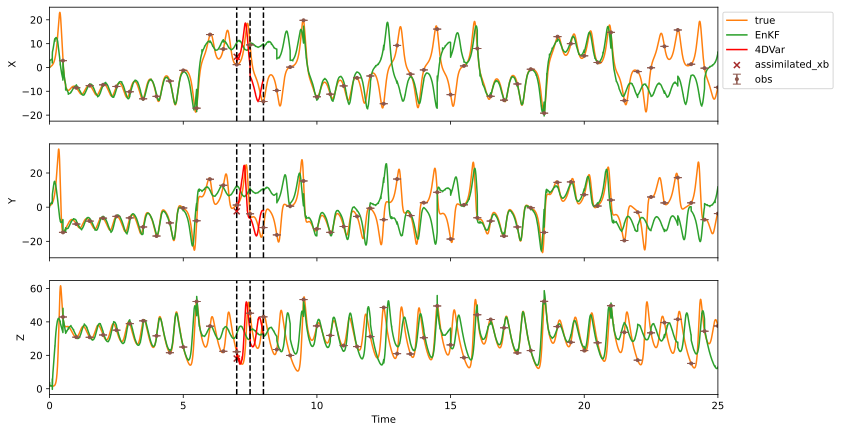

In [27]:
# Plot results
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 7), sharex=True)
iobs = 0
for k, comp in enumerate(["X", "Y", "Z"]):
    ax[k].plot(time.cpu(), xt.cpu()[k, :], color="#ff7f0e", label='true')
    # ax[k].plot(time.cpu(), lstm_outs.detach().numpy()[k, :], color="#1f77b4", label='lstm')
    ax[k].plot(time.cpu(), xEnKF.cpu()[k, :], color="#2ca02c", label='EnKF')
    ax[k].plot(var4d_times.cpu(), outs.detach().numpy()[k, :], color="red", label='4DVar')
    if WhichVariablesAreObserved[k] > 0:
        ax[k].errorbar(time_obs.cpu(), y.cpu()[iobs, :],
                       yerr=sqrt_s.cpu()[iobs, iobs], color="#8c564b",
                       fmt='o', markersize=3, capsize=4, label='obs')
        ax[k].scatter(time_obs[start_time_point].cpu(), x0.cpu()[k],
                      color="brown", marker="x", label='assimilated_xb')
        # ax[k].legend(bbox_to_anchor=(1, 1), loc='best', frameon=True)
        iobs += 1
    ax[k].set_ylabel(comp)
    for x in time_obs[start_time_point:end_time_point]:
        ax[k].axvline(x, color="k", linestyle="--")
ax[-1].set_xlabel('Time')
ax[-1].set_xlim(time.cpu()[0], time.cpu()[-1])
ax[0].legend(bbox_to_anchor=(1, 1), loc='best', frameon=True)
plt.show()

In [28]:
noda_cum_error = torch.sum((xt[:, time_idxs[0]:time_idxs[-1]+1] - lstm_outs.detach().numpy()[:, time_idxs[0]:time_idxs[-1]+1]) ** 2)
enkf_cum_error = torch.sum((xt[:, time_idxs[0]:time_idxs[-1]+1] - xEnKF[:, time_idxs[0]:time_idxs[-1]+1]) ** 2)
var4d_cum_error = torch.sum((xt[:, time_idxs[0]:time_idxs[-1]+1] - outs.detach().numpy()) ** 2)
norm = torch.sum(xt[:, time_idxs[0]:time_idxs[-1]+1]**2)
print("Relative errors (RRMSE) in %")
print(f"3-component: {100.0 * torch.sqrt(noda_cum_error / norm):.1f} (No DA)")
print(f"3-component: {100.0 * torch.sqrt(enkf_cum_error / norm):.1f} (EnKF)")
print(f"3-component: {100.0 * torch.sqrt(var4d_cum_error / norm):.1f} (4DVar)\n")
print("Relative errors (MSE) in %")
print(f"3-component: {100.0 * torch.mean((xt[:, time_idxs[0]:time_idxs[-1]+1] - lstm_outs.detach().numpy()[:, time_idxs[0]:time_idxs[-1]+1]) ** 2):.1f} (No DA)")
print(f"3-component: {100.0 * torch.mean((xt[:, time_idxs[0]:time_idxs[-1]+1] - xEnKF[:, time_idxs[0]:time_idxs[-1]+1]) ** 2):.1f} (EnKF)")
print(f"3-component: {100.0 * torch.mean((xt[:, time_idxs[0]:time_idxs[-1]+1] - outs.detach().numpy()) ** 2):.1f} (4DVar)")

Relative errors (RRMSE) in %
3-component: 77.8 (No DA)
3-component: 69.9 (EnKF)
3-component: 44.9 (4DVar)

Relative errors (MSE) in %
3-component: 24080.8 (No DA)
3-component: 19431.9 (EnKF)
3-component: 8010.3 (4DVar)


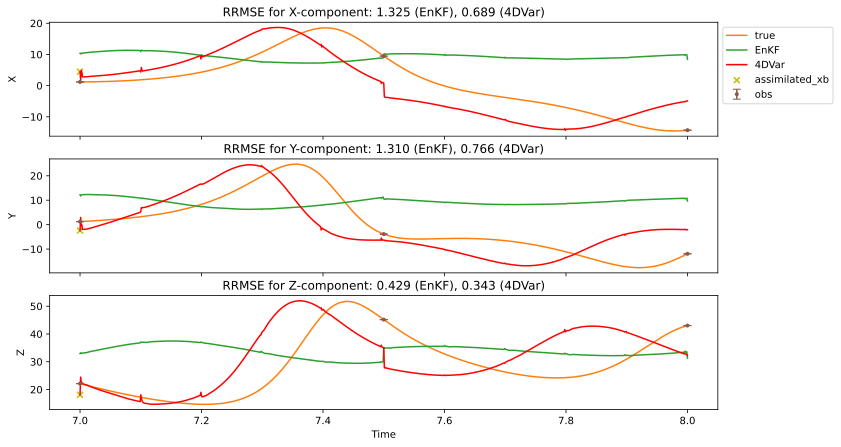

In [29]:
# Plot results
enkf_cum_error_comp = torch.sum((xt[:, time_idxs[0]:time_idxs[-1]+1] - xEnKF[:, time_idxs[0]:time_idxs[-1]+1]) ** 2, dim=1)
# enkf_cum_error_comp = torch.mean((xt[:, time_idxs[0]:time_idxs[-1]+1] - xEnKF[:, time_idxs[0]:time_idxs[-1]+1]) ** 2, dim=1)
var4d_cum_error_comp = torch.sum((xt[:, time_idxs[0]:time_idxs[-1]+1] - outs.detach().numpy()) ** 2, dim=1)
# var4d_cum_error_comp = torch.mean((xt[:, time_idxs[0]:time_idxs[-1]+1] - outs.detach().numpy()) ** 2, dim=1)
norm_comp = torch.sum(xt[:, time_idxs[0]:time_idxs[-1]+1]**2, dim=1)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 7), sharex=True)
iobs = 0
for k, comp in enumerate(["X", "Y", "Z"]):
    ax[k].plot(var4d_times.cpu(), xt.cpu()[k, time_idxs[0]:time_idxs[-1]+1], color="#ff7f0e", label='true')
    # ax[k].plot(var4d_times.cpu(), lstm_outs.detach().numpy()[k, time_idxs[0]:time_idxs[-1]+1], color="#1f77b4", label='lstm')
    ax[k].plot(var4d_times.cpu(), xEnKF.cpu()[k, time_idxs[0]:time_idxs[-1]+1], color="#2ca02c", label='EnKF')
    ax[k].plot(var4d_times.cpu(), outs.detach().numpy()[k, :], color="red", label='4DVar')
    if WhichVariablesAreObserved[k] > 0:
        ax[k].errorbar(time_obs.cpu()[start_time_point:end_time_point], y.cpu()[iobs, start_time_point:end_time_point],
                       yerr=sqrt_s.cpu()[iobs, iobs], color="#8c564b",
                       fmt='o', markersize=3, capsize=4, label='obs')
        ax[k].scatter(time_obs[start_time_point].cpu(), x0.cpu()[k],
                      color="y", marker="x", label='assimilated_xb')
        # ax[k].legend(bbox_to_anchor=(1, 1), loc='best', frameon=True)
        iobs += 1
    ax[k].set_ylabel(comp)
    ax[k].title.set_text(
        # f"RRMSE for {comp}-component: {100 * torch.sqrt(enkf_cum_error_comp[k] / norm_comp[k]):.3f}% (EnKF), {100 * torch.sqrt(var4d_cum_error_comp[k] / norm_comp[k]):.3f}% (4DVar)"
        f"RRMSE for {comp}-component: {torch.sqrt(enkf_cum_error_comp[k] / norm_comp[k]):.3f} (EnKF), {torch.sqrt(var4d_cum_error_comp[k] / norm_comp[k]):.3f} (4DVar)"
    )
ax[-1].set_xlabel('Time')
# ax[-1].set_xlim(time.cpu()[0], time.cpu()[-1])
ax[0].legend(bbox_to_anchor=(1, 1), loc='best', frameon=True)
plt.show()